In [1]:
import random
import lr_scheduler
import matplotlib.pyplot as plt
#from func import *
import func
import tensorflow as tf
import numpy as np

In [2]:
folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

In [3]:
AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42

PROJECT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
# Baseline Dataset
a = []
for jpg_path, npy_path in file_pairs:
    a.append([
        func.read_jpg_files(jpg_path),
        func.read_and_parse_npy_file(npy_path)
    ])
# a chứa file ảnh và file npy chỉ đọc nhưng chưa tách nối
# Biến đổi a
# Chuyển đổi list `a` thành tensor
images = np.array([item[0] for item in a])  # Lấy phần ảnh
npy_vectors = np.array([item[1] for item in a])  # Lấy phần npy vector



# Tạo dataset từ tensor
dataset = tf.data.Dataset.from_tensor_slices((images, npy_vectors))
# Map hàm `combine_data` để kết hợp ảnh và vector
dataset = dataset.map(
    lambda image, npy_vector: func.combine_data(image, npy_vector),
    num_parallel_calls=tf.data.AUTOTUNE
)
# Batch và prefetch
dataset = (
    dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [5]:
# No1. Augmentation Functions
def augment_image(image):
    if random.random() > 0.5:
        image = np.fliplr(image) # Lật trái-phải
    if random.random() > 0.5:
        image = np.flipud(image) # Lật trên-dưới
    
    crop_size = random.randint(5, 20)
    h, w = image.shape
    cropped_image = image[crop_size:h-crop_size, crop_size:w-crop_size]
    # Resize lại về kích thước ban đầu
    augmented_image = np.pad(cropped_image, ((crop_size, crop_size), (crop_size, crop_size)), mode='constant', constant_values=77)
    return augmented_image

def augment_vector(vector):
    noise = np.random.normal(0, 0.01, size=len(vector)) # Nhiễu với độ lệch chuẩn 0.01
    augmented_vector = [v + n for v, n in zip(vector, noise)]
    return augmented_vector

def apply_augmentation(data):
    image, vector = data
    augmented_image = augment_image(image)
    augmented_vector = augment_vector(vector)
    return augmented_image, augmented_vector

In [6]:
# No1. Dataset
augmented_data = [apply_augmentation(data) for data in a]
# Chuyển đổi list `augmented_data` thành tensor
images2 = np.array([item[0] for item in augmented_data])  # Lấy phần ảnh
npy_vectors2 = np.array([item[1] for item in augmented_data])  # Lấy phần npy vector

# Tạo dataset từ tensor
dataset2 = tf.data.Dataset.from_tensor_slices((images2, npy_vectors2))
# Map hàm `combine_data` để kết hợp ảnh và vector
dataset2 = dataset2.map(
    lambda image, npy_vector: func.combine_data(image, npy_vector),
    num_parallel_calls=tf.data.AUTOTUNE
)
# Batch và prefetch
dataset2 = (
    dataset2
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
# No2. Augmentation Functions


In [8]:
BL_ds = tf.data.Dataset.zip((dataset, dataset2))

In [9]:
STEPS_PER_EPOCH = 597 // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = lr_scheduler.WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

In [10]:
def create_mlp_encoder(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512, activation="relu")(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation=None)(x)  # Projection head
    return tf.keras.Model(inputs, x)

BL_ds_test = BL_ds

# 2. Tạo mô hình Barlow Twins
encoder = create_mlp_encoder(input_dim=16392)
barlow_twins = func.BarlowTwins(encoder=encoder)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins.compile(optimizer=optimizer)
history = barlow_twins.fit(BL_ds_test, epochs=EPOCHS)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 53.6860
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 35.0438
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 35.1037
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 33.1825
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 28.6754
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.2056
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.8954
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.5073
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.3069
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.0079
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 22.2479
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21.4759
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 20.8349
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21.5902
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - los

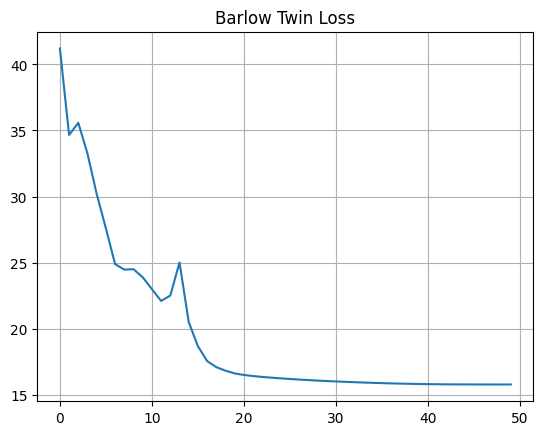

In [11]:
# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

In [12]:
# Save
barlow_twins.save_weights('bl.weights.h5')